<a href="https://colab.research.google.com/github/tanish1403/Malaria_detection/blob/main/Malaria_detection_first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
mal_dataset, data_info =  tfds.load('malaria', with_info = True, as_supervised =True, shuffle_files = True, split = ["train"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteY0MD67/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataset = tf.data.Dataset.range(10)
print(list(dataset.as_numpy_iterator()))
dataset_size = len(dataset)

train_dataset = dataset.take(int(train_ratio*dataset_size))
print(list(train_dataset.as_numpy_iterator()))

val_dataset = dataset.skip(int(train_ratio * dataset_size))
val_dataset = val_dataset.take(int(val_ratio*dataset_size))
print(list(val_dataset.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7]
[8]


In [ ]:
def splits(dataset, train_ratio, val_ratio, test_ratio):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(train_ratio*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(train_ratio*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(val_ratio*DATASET_SIZE))

    test_dataset =val_test_dataset.skip(int(val_ratio*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_dataset, val_dataset, test_dataset = splits(mal_dataset[0], train_ratio, val_ratio, test_ratio)


## Data Visualization

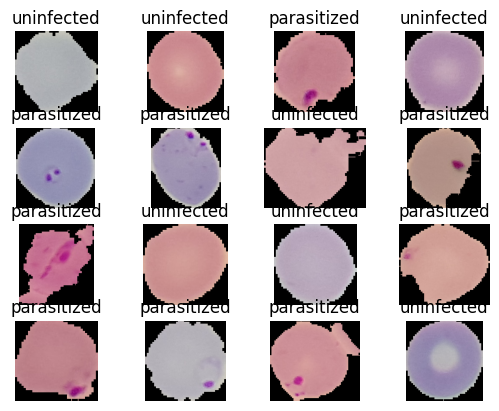

In [ ]:
for i, (img, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.title(data_info.features['label'].int2str(label))
    plt.axis('off')

In [ ]:
IM_SIZE = 224
def resize_rescale(img, label):
    return tf.image.resize(img, (IM_SIZE, IM_SIZE))/255.0,label


In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for img,label in train_dataset.take(1):
    print(img,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
BATCH_SIZE=32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
model_1 = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    BatchNormalization(),
    Conv2D(filters=6, kernel_size=5,strides=1, padding = 'valid', activation='sigmoid'),
    MaxPool2D(pool_size = 2, strides=2),

    Conv2D(filters=160, kernel_size=5, strides=1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(1000, activation='sigmoid'),
    Dense(100, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 160)     24160     
                                                                 
 batch_normalization_1 (Bat  (None, 106, 106, 160)     640       
 chNormalization)                                                
                                                        

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
model_1.compile(optimizer = Adam(learning_rate = 0.01),
             loss = BinaryCrossentropy(),
             )

In [ ]:
history = model_1.fit(train_dataset, validation_data = val_dataset, epochs =5, verbose =1 )

Epoch 1/5
689/689 [==============================] - 165s 196ms/step - loss: 0.7300 - val_loss: 0.6934
Epoch 2/5
689/689 [==============================] - 121s 176ms/step - loss: 0.7027 - val_loss: 0.6987
Epoch 3/5
689/689 [==============================] - 153s 222ms/step - loss: 0.7038 - val_loss: 0.6982
Epoch 4/5
689/689 [==============================] - 151s 219ms/step - loss: 0.7033 - val_loss: 0.6964
Epoch 5/5
689/689 [==============================] - 120s 174ms/step - loss: 0.7029 - val_loss: 0.7002


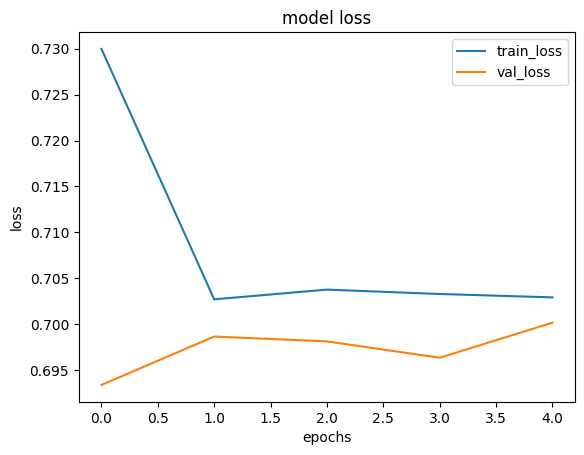

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
model_1.evaluate(test_dataset)

87/87 [==============================] - 14s 47ms/step - loss: 0.6982


0.6981641054153442

In [ ]:
model_1.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.44454658

In [ ]:
def parasite_or_not(x):
  if (x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(model_1.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 10s 10s/step


'P'

1/1 [==============================] - 0s 34ms/step


ValueError: ignored

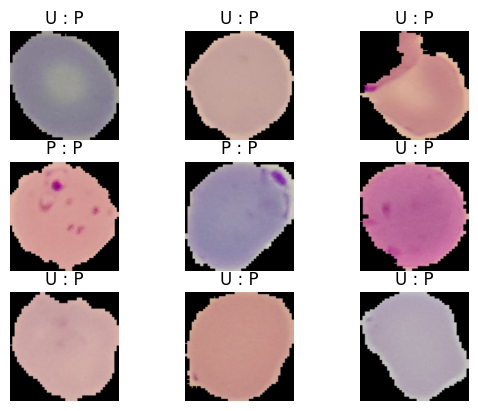

In [ ]:
for i , (img,label) in enumerate(test_dataset):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(img[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+" : "+str(parasite_or_not(model_1.predict(img)[0][0])))
  plt.axis("off")